In [1]:
# Mute warining
import warnings
warnings.filterwarnings("ignore")

In [2]:
## <===================== model initiate =====================>
def step_1_model_init(ml_methed, n_jobs=-1, rng=666666):
    ml_methed = ml_methed.lower()
    ## -------------------- random forest --------------------
    if ml_methed in ['rf', 'random forest', 'randomforest']:
        from sklearn.ensemble import RandomForestRegressor
        sk_model = RandomForestRegressor(random_state=rng, oob_score=True, n_jobs=n_jobs)
        search_space = {'n_estimators': [50, 200, 500], 'max_depth': [2, 4, 6], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [5, 10, 25, 50], 'min_samples_split': [2, 5, 8, 10]}

    ## -------------------- SVM --------------------
    elif ml_methed in ['svm', 'support vector machine', 'supportvectormachine']:
        from sklearn.svm import SVR
        sk_model = SVR(kernel="rbf", gamma=0.1)
        search_space = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'], 'C': [0.1, 1, 10, 100]}

    ## -------------------- MLP --------------------
    elif ml_methed in ['mlp', 'ann']:
        from sklearn.neural_network import MLPRegressor
        sk_model = MLPRegressor(random_state=rng, max_iter=100, early_stopping=True)
        search_space = {'hidden_layer_sizes': [(128,), (128, 128), (128, 128, 128)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.1, 0.01, 0.001, 0.0001]}

    ## -------------------- KNN --------------------
    elif ml_methed in ['knn', 'k-nn', 'nearest neighbor', 'nearestneighbor']:
        from sklearn.neighbors import KNeighborsRegressor
        sk_model = KNeighborsRegressor(n_neighbors=3, n_jobs=n_jobs)
        search_space = {'n_neighbors': [1, 3, 5, 10]}

    ## -------------------- Linear --------------------
    else:
        if ml_methed != 'linear':
            print(f"Error! no proper ML methods were selected, using Linear method instead")
        from sklearn.linear_model import LinearRegression
        sk_model = LinearRegression(n_jobs=n_jobs)
        search_space = None

    return sk_model, search_space

## <===================== model training =====================>
def _HyperParamSearch(sk_model, X, y, search_space=None, search_method='grid', scoring='neg_mean_absolute_error', nFolds=5, n_jobs=-1):
    print(f"\t\tStart Hyper-Parameter Tunning ...")
    SearchResults = {'best_model': None, 'best_score':None, 'best_param':None}

    # if search_method == 'grid':
    from sklearn.model_selection import GridSearchCV
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    optimizer = GridSearchCV(estimator=sk_model, param_grid=search_space, scoring=scoring, cv=nFolds, n_jobs=n_jobs)
    optimizer.fit(X, y)
    ## search results
    SearchResults['optimizer'] = optimizer    ## optimizer.best_estimator_, optimizer.best_score_
    SearchResults['best_param'] = optimizer.best_estimator_.get_params()

    ## export
    print(f"\t\tThe best {scoring}: {SearchResults['best_score']}\n\t\tThe best hp-params: {SearchResults['best_param']}")
    print(f"\t\tComplete Hyper-Parameter Tunning ...")
    return SearchResults

##
def step_2_model_training(sk_model, X, y, logy=False, doHPT=False, search_space=None, scoring='neg_mean_absolute_error', n_jobs=-1):
    import time   
    beginTime = time.time()        
    ## ----------------------------------------------------------------
    import numpy as np
    # X = X.to_numpy()
    y = y.to_numpy().reshape((len(y), ))
    y = np.log10(y) if logy else y

    ## ----- hyper parameter search ----------------
    if doHPT and search_space is not None:
        HPSearchResults = _HyperParamSearch(sk_model, X, y, search_space, search_method='grid', scoring=scoring, nFolds=5, n_jobs=n_jobs)
        sk_model = sk_model.set_params(**HPSearchResults['best_param'])    #optimizer.best_estimator_

    ## ----- fit the model -----
    sk_model.fit(X, y)

    ## ----------------------------------------------------------------        
    print(f"\t\tThe model training costs time = {(time.time()-beginTime):.2f} s ................")
    return sk_model

## <===================== model predict =====================>
def step_3_make_prediction(sk_model, X, logy=False):
    y_pred = sk_model.predict(X)
    y_pred = 10**y_pred if logy else y_pred
    return y_pred

## <===================== model evaluate =====================>
def step_4_make_comparison(y_pred, y_true, label='dataset'):
    dataDict_evaluation = {}
    try:
        y_pred = y_pred.reshape((len(y_pred), ))
        y_true = y_true.reshape((len(y_true), ))

        from sklearn.metrics import mean_absolute_error
        from numpy import corrcoef
        from scipy.stats import spearmanr, kendalltau
        dataDict_evaluation[f'{label}_MAE'] = float(mean_absolute_error(y_pred, y_true))    ## mean absolute error
        dataDict_evaluation[f'{label}_Pearson_R2'] = float(corrcoef(y_pred, y_true)[0, 1])**2    ## PearsonCorrelationCoefficient
        dataDict_evaluation[f'{label}_Spearman_R2'] = float(spearmanr(y_pred, y_true)[0])**2    ## rank-order correlation
        dataDict_evaluation[f'{label}_KendallTau_R2'] = float(kendalltau(y_pred, y_true)[0])**2        ## Kendall's tau
    except Exception as e:
        print(f"\t\tCannot compare y_pred & y_true: {e}")
    else:          
        ## print out the results
        # print(f"\t\tData shape: y_pred {y_pred.shape}; y_true {y_true.shape}")
        mae = round(dataDict_evaluation[f'{label}_MAE'], 2)
        pr2 = round(dataDict_evaluation[f'{label}_Pearson_R2'], 2)
        sr2 = round(dataDict_evaluation[f'{label}_Spearman_R2'], 2)
        print(f"\t\t{label}=> MAE: {mae}; Pearson-R2: {pr2}; Spearman-R2: {sr2}")
        # print(f"\t\tKendall-R2: {dataDict_evaluation['KendallTau_R2']:.2f}")
    return dataDict_evaluation

## <===================== resultl plot =====================>
def step_5_plot_pred_vs_expt(dataTable, colName_x='Prediction', colName_y='Experiment', colName_color='Split', take_log=True, diagonal=True, sideHist=True, figTitle=None, outputFolder='./Plot'):
    ## --------- Start with a square Figure ---------
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 8))
    x, y = dataTable[colName_x], dataTable[colName_y]
    if take_log:
        import numpy as np
        x, y = np.log10(x), np.log10(y)
        label_x = f"Prediction(log)" if take_log else 'Prediction'    # f"{colName_x}(log)" if take_log else colName_x
        label_y = f"Experiment(log)" if take_log else 'Experiment'    # f"{colName_y}(log)" if take_log else colName_y

    ## --------- add histgram along each side of the axis ---------
    if sideHist:
        gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 6), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1, 0])
        ## add hist
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        bins = 20        
        ax_histx.hist(x, bins=bins)
        ax_histy.hist(y, bins=bins, orientation='horizontal')
            
        ax_histx.tick_params(axis="x", labelbottom=False)    # no x labels
        ax_histy.tick_params(axis="y", labelleft=False)    # no y labels

        ax_histx.tick_params(axis='both', which='major', labelsize=16)
        ax_histy.tick_params(axis='both', which='major', labelsize=16)
    else:
        ax = fig.add_subplot()
        
    ## --------- add scatter plot ---------
    if colName_color is None:
        ax.scatter(x, y, s=40, alpha=0.5, cmap='Spectral', marker='o')
    else:
        for i in sorted(dataTable[colName_color].unique()):
            idx = dataTable[dataTable[colName_color]==i].index.to_list()
            ax.scatter(x.loc[idx], y.loc[idx], s=40, alpha=0.5, cmap='Spectral', marker='o', label=i)
        ax.legend(loc="best", title=colName_color)    #, bbox_to_anchor=(1.35, 0.5)
        # ax.legend(loc="upper left", title=colName_color)    #, bbox_to_anchor=(1.35, 0.5)

        
    ## --------- config the figure params ---------
    ax.set_xlabel(label_x, fontsize=16)
    ax.set_ylabel(label_y, fontsize=16)

    ## determine axis limits  
    ax_max, ax_min = max(np.max(x), np.max(y)), min(np.min(x), np.min(y))
    ax_addon = (ax_max - ax_min)/10
    ax_max = ax_max + ax_addon
    ax_min = ax_min - ax_addon
    ax.set_xlim([ax_min, ax_max])
    ax.set_ylim([ax_min, ax_max])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(alpha=0.75)
    if diagonal: 
        diagonalLine = ax.plot([ax_min, ax_max], [ax_min, ax_max], c='lightgray', linestyle='-')        

    figTitle = f"Pred vs Expt" if figTitle is None else figTitle
    fig.suptitle(figTitle, fontsize=24)

    ## --------- Save the figure ---------
    import os
    os.makedirs(outputFolder, exist_ok=True)
    figPath = f"{outputFolder}/{figTitle}.png"
    plt.savefig(figPath)
    return figPath

## <===================== others =====================>


	Training_X: (24, 23); Training_y: (24,)
	Validation_X: (3, 23); Validation_y: (3,)
	Test_X: (3, 23); Test_y: (3,)
	>>Now training the <linear> model
		The model training costs time = 0.03 s ................
		Training=> MAE: 0.08; Pearson-R2: 1.0; Spearman-R2: 0.99
		Validation=> MAE: 11.55; Pearson-R2: 0.56; Spearman-R2: 0.25
		Test=> MAE: 5.44; Pearson-R2: 0.37; Spearman-R2: 0.25
	>>Now training the <rf> model
		Start Hyper-Parameter Tunning ...
		The best neg_mean_absolute_error: None
		The best hp-params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': True, 'random_state': 666666, 'verbose': 0, 'warm_start': False}
		Complete Hyper-Parameter Tunning ...
		The model training costs time = 28.72 s ....

/mnt/data0/software/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/data0/software/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/data0/software/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/data0/software/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged ye

		The best neg_mean_absolute_error: None
		The best hp-params: {'activation': 'tanh', 'alpha': 0.1, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (128, 128), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 666666, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
		Complete Hyper-Parameter Tunning ...
		The model training costs time = 0.95 s ................
		Training=> MAE: 2.53; Pearson-R2: 0.03; Spearman-R2: 0.31
		Validation=> MAE: 10.73; Pearson-R2: 0.08; Spearman-R2: 0.25
		Test=> MAE: 4.49; Pearson-R2: 0.95; Spearman-R2: 1.0
	>>Now training the <knn> model
		Start Hyper-Parameter Tunning ...
		The best neg_mean_absolute_error: None
		The best hp-params: {'algorithm': 'auto', 'leaf_size': 30, 'metri

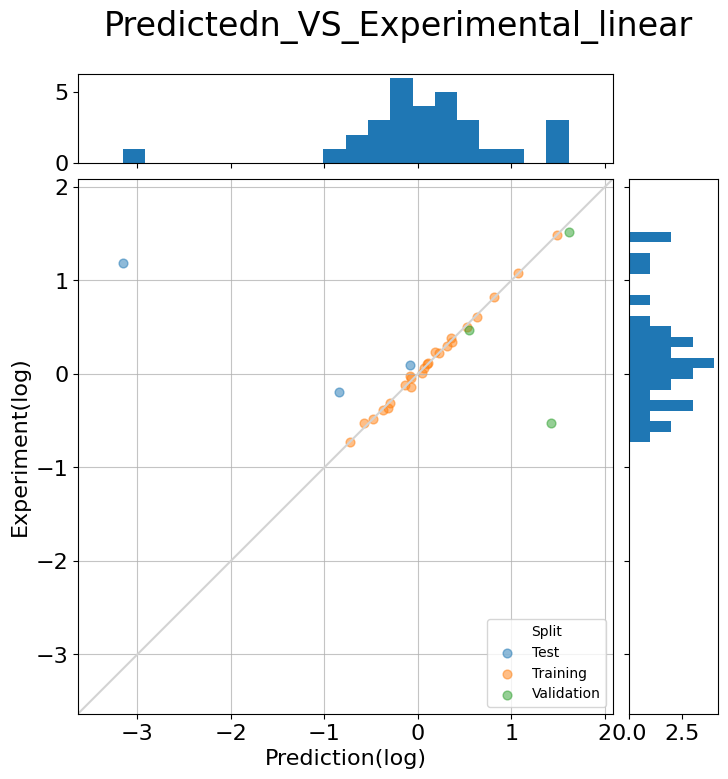

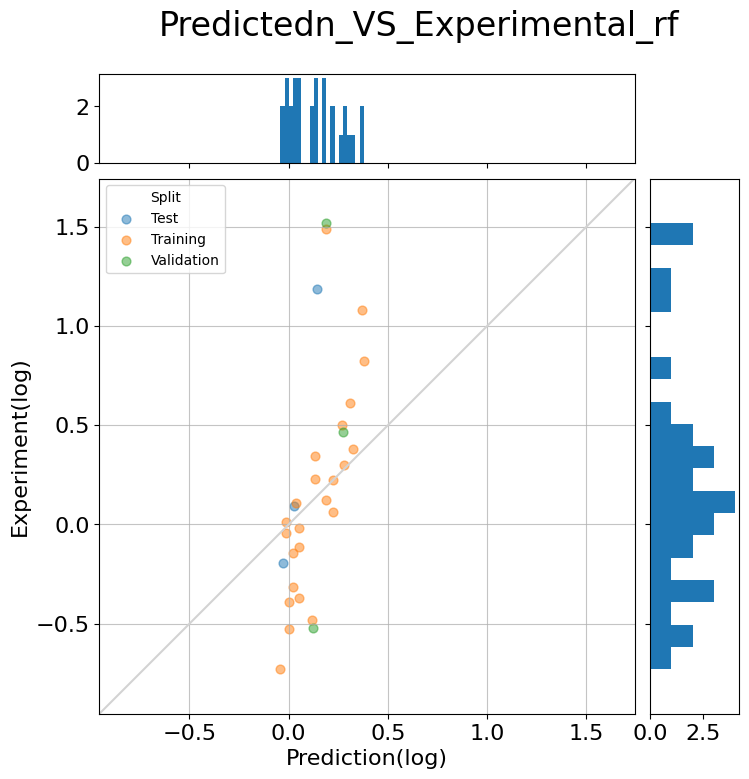

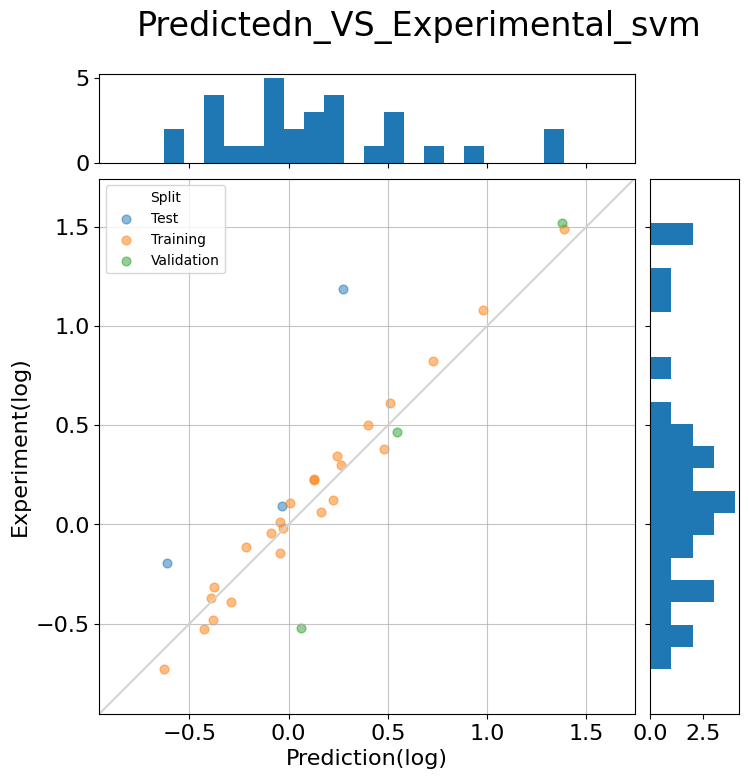

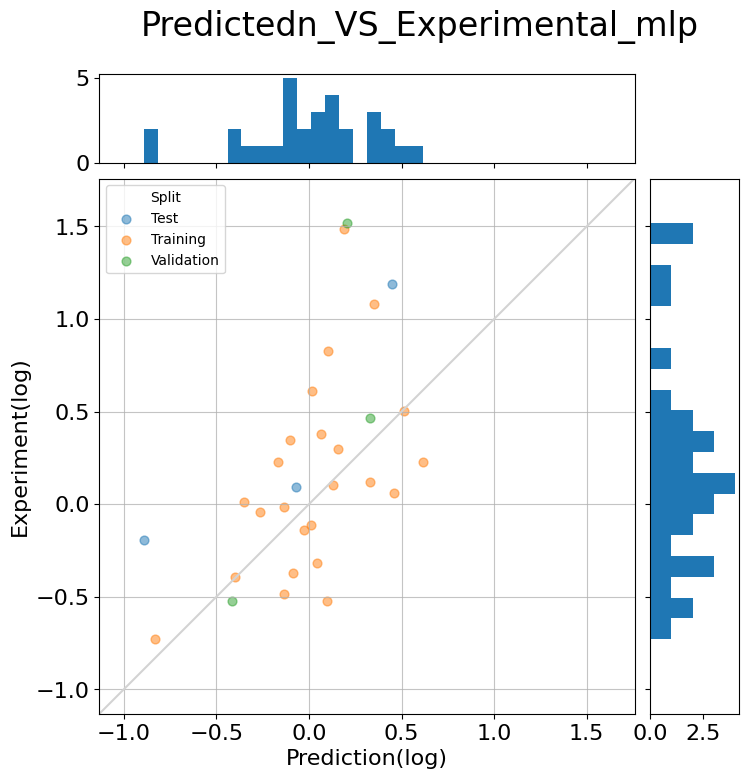

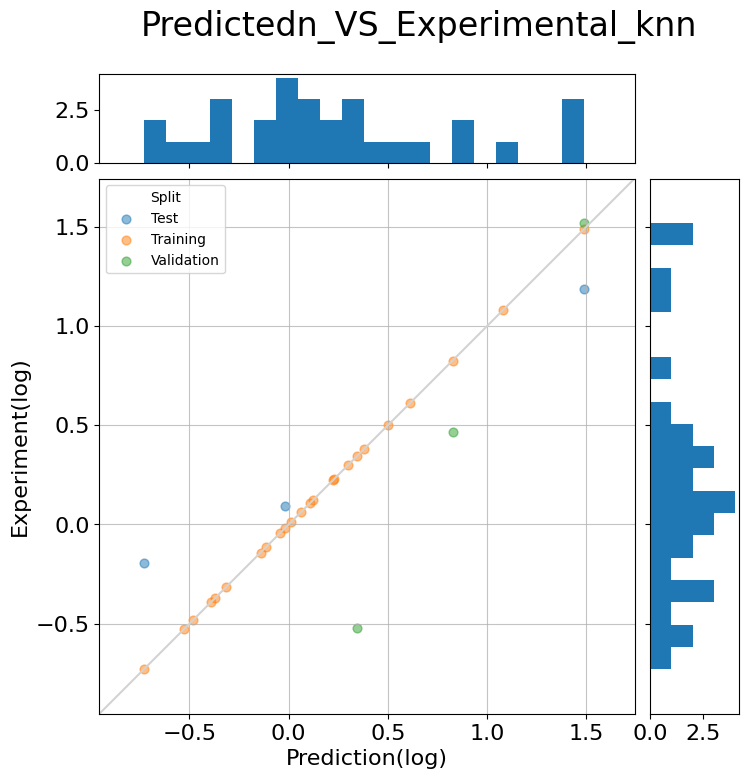

In [3]:
##----------------------------------------------------------------------------------------
fileNameIn = './results/data_input_4_ModelBuilding.csv'
colName_mid = 'Compound Name'
colName_split = 'Split'
colName_y = 'ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)'
sep = ','

n_jobs = -1
rng = 666666
logy = True
doHPT = True
scoring = 'neg_mean_absolute_error'
ml_methed_list = ['linear', 'rf', 'svm', 'mlp', 'knn']

import os
folderPathOut = './results'    ## './results'
os.makedirs(folderPathOut, exist_ok=True)
folderPathOut_plot = f"{folderPathOut}/Plot"
os.makedirs(folderPathOut_plot, exist_ok=True)

##----------------------------------------------------------------------------------------
import pandas as pd
dataTable_raw = pd.read_csv(fileNameIn, sep=sep)
colName_X = [col for col in dataTable_raw.columns if col not in [colName_mid, colName_split, colName_y]]

## training
dataTable_train = dataTable_raw[dataTable_raw[colName_split]=='Training']
X_train, y_train = dataTable_train[colName_X], dataTable_train[colName_y]
print(f"\tTraining_X: {X_train.shape}; Training_y: {y_train.shape}")

## validation
dataTable_val = dataTable_raw[dataTable_raw[colName_split]=='Validation']
X_val, y_val = dataTable_val[colName_X], dataTable_val[colName_y]
print(f"\tValidation_X: {X_val.shape}; Validation_y: {y_val.shape}")

## test
dataTable_test = dataTable_raw[dataTable_raw[colName_split]=='Test']
X_test, y_test = dataTable_test[colName_X], dataTable_test[colName_y]
print(f"\tTest_X: {X_test.shape}; Test_y: {y_test.shape}")


##----------------------------------------------------------------------------------------
model_dict = {'data': {'Desc': colName_X, 'ExptOutcome': colName_y, 'Train': dataTable_train[colName_mid], 'Val': dataTable_val[colName_mid], 'Test': dataTable_test[colName_mid]},
              'config': {'rng': rng, 'n_jobs':n_jobs, 'logy': logy, 'doHPT': doHPT}, 
              'model': {}, 'results': None, 'evaluation': {}, 'plot': {}}

##
for ml_methed in ml_methed_list:
    print(f"\t>>Now training the <{ml_methed}> model")
    ## training
    sk_model, search_space = step_1_model_init(ml_methed, n_jobs=n_jobs, rng=rng)
    sk_model = step_2_model_training(sk_model, X_train, y_train, logy=logy, doHPT=doHPT, search_space=search_space, scoring=scoring, n_jobs=n_jobs) 
    model_dict['model'][ml_methed] = sk_model

    ## prediction
    col_pred = f"Prediction_{ml_methed}_{colName_y}"
    dataTable_train[col_pred] = step_3_make_prediction(sk_model, X_train, logy=logy)
    dataTable_val[col_pred] = step_3_make_prediction(sk_model, X_val, logy=logy)
    dataTable_test[col_pred] = step_3_make_prediction(sk_model, X_test, logy=logy)

    ## evaluation stats
    model_dict['evaluation'][ml_methed] = {}
    model_dict['evaluation'][ml_methed]['ML_Algorithm'] = ml_methed
    model_dict['evaluation'][ml_methed].update(step_4_make_comparison(dataTable_train[col_pred].to_numpy(), dataTable_train[colName_y].to_numpy(), label='Training'))
    model_dict['evaluation'][ml_methed].update(step_4_make_comparison(dataTable_val[col_pred].to_numpy(), dataTable_val[colName_y].to_numpy(), label='Validation'))
    model_dict['evaluation'][ml_methed].update(step_4_make_comparison(dataTable_test[col_pred].to_numpy(), dataTable_test[colName_y].to_numpy(), label='Test'))
    
    ## plot pred vs expt
    model_dict['plot'][ml_methed] = step_5_plot_pred_vs_expt(dataTable=pd.concat([dataTable_train, dataTable_val, dataTable_test]), 
                                                             colName_x=col_pred, colName_y=colName_y, colName_color=colName_split, 
                                                             take_log=True, diagonal=True, sideHist=True, outputFolder=folderPathOut_plot, 
                                                             figTitle=f"Predictedn_VS_Experimental_{ml_methed}")

## merge/concact data
dataTable_list = [dataTable_train, dataTable_val, dataTable_test]
model_dict['results'] = pd.concat(dataTable_list).sort_index(ascending=True)
model_dict['evaluation'] = pd.DataFrame.from_dict(model_dict['evaluation']).T

## find best model
dataTable_eval = model_dict['evaluation']
# select_matrics, select_standar = 'Validation_MAE', 'min'
# select_matrics, select_standar = 'Validation_Pearson_R2', 'max'
select_matrics, select_standar = 'Validation_Spearman_R2', 'max'
if select_standar in ['min']:
    model_dict['selection'] = dataTable_eval.loc[dataTable_eval[select_matrics].idxmin()]['ML_Algorithm']
elif select_standar in ['max']:
    model_dict['selection'] = dataTable_eval.loc[dataTable_eval[select_matrics].idxmax()]['ML_Algorithm']
else:
    print(f"\tThe select_standar should be selected from [max, min]")
    model_dict['selection'] = None

##----------------------------------------------------------------------------------------
## save predictions
fileNameOut_pred = f"{folderPathOut}/prediction_results.csv"
model_dict['results'].to_csv(fileNameOut_pred, index=False)

## save statistics
fileNameOut_eval = f"{folderPathOut}/evaluation_results.csv"
model_dict['evaluation'].to_csv(fileNameOut_eval, index=False)

## save models
import pickle
fileNameOut_model = f"{folderPathOut}/ml_models.pickle"
with open(fileNameOut_model, 'wb') as ofh_models:
    pickle.dump(model_dict, ofh_models)

In [4]:
## load models
import pickle
fileNameOut_model = f"{folderPathOut}/ml_models.pickle"
with open(fileNameOut_model, 'rb') as ifh_models:
    model_dict_load = pickle.load(ifh_models)


In [5]:
model_dict_load['results']

,Compound Name,Split,ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),rd_MinEStateIndex,rd_qed,rd_MolWt,rd_HeavyAtomMolWt,rd_MinPartialCharge,rd_MaxAbsPartialCharge,rd_MinAbsPartialCharge,...,rd_fr_Al_OH_noTert,rd_fr_amide,rd_fr_imide,custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%),custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num),Prediction_linear_ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),Prediction_rf_ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),Prediction_svm_ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),Prediction_mlp_ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num),Prediction_knn_ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)
0,KT-0005056,Training,6.688280,-0.163761,-0.227408,0.515281,0.521866,1.378307,-2.231234,-0.330432,...,-0.267261,-0.536045,-0.423999,0.354194,-0.425073,6.546845,2.386431,5.312098,1.264449,6.688280
1,KT-0005058,Training,1.987887,-1.313163,-0.384718,0.533872,0.502582,1.141667,-0.566683,0.622913,...,-0.267261,-0.536045,-0.423999,0.086802,-0.576509,2.029415,1.902301,1.826453,1.435885,1.987887
2,KT-0005246,Training,1.029547,-1.300730,-0.127737,0.107370,0.140862,-1.094728,1.180911,1.418473,...,-0.267261,0.862333,1.165998,-0.362470,-0.685627,1.109572,0.968483,0.900858,0.447011,1.029547
3,KT-0005250,Training,0.960066,1.026061,-0.363501,0.357337,0.354196,-1.094728,1.180911,-1.205210,...,-0.267261,0.862333,1.165998,-0.440282,-0.681985,0.817156,1.131136,0.941335,0.734163,0.960066
4,KT-0005061,Validation,32.953901,1.230172,2.465871,-2.344253,-2.331667,-0.888364,0.896183,-1.483848,...,3.741657,-1.934422,-2.013996,1.714511,2.607380,40.929670,1.538168,23.826937,1.607809,30.635056
5,KT-0001879,Training,2.207218,-0.203380,-0.637723,0.460518,0.457228,-0.049590,-0.261108,-0.330922,...,-0.267261,0.163144,-0.423999,-0.392326,0.372050,2.333807,1.363694,1.754483,0.791091,2.207218
6,KT-0005057,Training,1.153111,-1.359481,-0.456584,0.484809,0.489518,2.487982,-0.566683,-0.481534,...,-0.267261,-0.536045,-0.423999,-0.813372,-0.694199,1.174941,1.663623,1.450641,2.880758,1.153111
7,KT-0001844,Test,15.407308,1.302671,3.589610,-2.782399,-2.777284,-0.016867,-0.306257,1.105826,...,-0.267261,-1.235233,-2.013996,2.000106,2.559574,0.000696,1.395083,1.872737,2.824450,30.635056
8,KT-0005249,Training,1.276836,1.029773,-0.091511,-0.135377,-0.149350,-1.094728,1.180911,-1.262249,...,-0.267261,0.862333,1.165998,-0.338426,-0.663004,1.266785,1.084229,1.013390,1.346266,1.276836
9,KT-0001038,Training,0.328750,-0.270643,-0.840286,1.731369,1.786827,-0.397614,0.219075,-0.779833,...,-0.267261,2.260710,1.165998,1.047898,0.132478,0.329398,1.310558,0.413641,0.736682,0.328750


In [6]:
model_dict_load['model']

{'linear': LinearRegression(n_jobs=-1),
 'rf': RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=5,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=666666),
 'svm': SVR(C=10),
 'mlp': MLPRegressor(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=(128, 128), max_iter=100, random_state=666666),
 'knn': KNeighborsRegressor(n_jobs=-1, n_neighbors=1)}

In [7]:
model_dict_load['evaluation']

,ML_Algorithm,Training_MAE,Training_Pearson_R2,Training_Spearman_R2,Training_KendallTau_R2,Validation_MAE,Validation_Pearson_R2,Validation_Spearman_R2,Validation_KendallTau_R2,Test_MAE,Test_Pearson_R2,Test_Spearman_R2,Test_KendallTau_R2
linear,linear,0.079269,0.999697,0.987863,0.928849,11.553156,0.561658,0.25,0.111111,5.442147,0.367884,0.25,0.111111
rf,rf,2.258332,0.126731,0.656805,0.379385,11.161311,0.004051,0.25,0.111111,4.825856,0.939293,1.0,1.0
svm,svm,0.643726,0.997348,0.955294,0.807393,3.52621,0.99947,1.0,1.0,4.748506,0.851184,1.0,1.0
mlp,mlp,2.529395,0.02686,0.3136,0.147501,10.733507,0.08481,0.25,0.111111,4.494308,0.949077,1.0,1.0
knn,knn,0.0,1.0,1.0,1.0,2.665906,0.99438,1.0,1.0,5.321574,0.999815,1.0,1.0


In [8]:
model_dict_load['data']

{'Desc': ['rd_MinEStateIndex',
  'rd_qed',
  'rd_MolWt',
  'rd_HeavyAtomMolWt',
  'rd_MinPartialCharge',
  'rd_MaxAbsPartialCharge',
  'rd_MinAbsPartialCharge',
  'rd_FpDensityMorgan1',
  'rd_AvgIpc',
  'rd_BalabanJ',
  'rd_BertzCT',
  'rd_HallKierAlpha',
  'rd_Kappa2',
  'rd_TPSA',
  'rd_FractionCSP3',
  'rd_HeavyAtomCount',
  'rd_NumAliphaticRings',
  'rd_NumSaturatedRings',
  'rd_fr_Al_OH_noTert',
  'rd_fr_amide',
  'rd_fr_imide',
  'custDesc_ADME MDCK(WT) Permeability;Mean;A to B Recovery (%)',
  'custDesc_ADME MDCK(WT) Permeability;Mean;B to A Papp (10^-6 cm/s);(Num)'],
 'ExptOutcome': 'ADME MDCK(WT) Permeability;Mean;A to B Papp (10^-6 cm/s);(Num)',
 'Train': 0     KT-0005056
 1     KT-0005058
 2     KT-0005246
 3     KT-0005250
 5     KT-0001879
 6     KT-0005057
 8     KT-0005249
 9     KT-0001038
 10    KT-0005054
 11    KT-0001685
 12    KT-0001675
 13    KT-0006300
 15    KT-0005062
 16    KT-0004037
 17    KT-0005244
 18    KT-0004040
 19    KT-0005059
 20    KT-0002321
 22

In [9]:
model_dict_load['evaluation']

,ML_Algorithm,Training_MAE,Training_Pearson_R2,Training_Spearman_R2,Training_KendallTau_R2,Validation_MAE,Validation_Pearson_R2,Validation_Spearman_R2,Validation_KendallTau_R2,Test_MAE,Test_Pearson_R2,Test_Spearman_R2,Test_KendallTau_R2
linear,linear,0.079269,0.999697,0.987863,0.928849,11.553156,0.561658,0.25,0.111111,5.442147,0.367884,0.25,0.111111
rf,rf,2.258332,0.126731,0.656805,0.379385,11.161311,0.004051,0.25,0.111111,4.825856,0.939293,1.0,1.0
svm,svm,0.643726,0.997348,0.955294,0.807393,3.52621,0.99947,1.0,1.0,4.748506,0.851184,1.0,1.0
mlp,mlp,2.529395,0.02686,0.3136,0.147501,10.733507,0.08481,0.25,0.111111,4.494308,0.949077,1.0,1.0
knn,knn,0.0,1.0,1.0,1.0,2.665906,0.99438,1.0,1.0,5.321574,0.999815,1.0,1.0


In [10]:
model_dict_load['selection']

'svm'

In [11]:
# best_model = model_dict_load['model'][model_dict_load['selection']]

SVR(C=10)